# Churn Prediction

## Problem Statement

There is a telecom company that offers phone and internet services. There is a problem: some of our customers are churning. We would like to build a model that can identify the customers that are likely to churn. We have collected a dataset about our customers: what type of services they use, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). 

## What's in this section

In this notebook, we are going to perform hyperparameter tuning of models as discussed in the previous notebook : `churn_prediction_model_training_phase_III` . In the previous notebook we said :

Based on `fbeta score (beta = 1.5)` , we can select following models to further hyperparameter tuning:
- Logistic Regression with smote (Fbeta score = 0.685354)
- Random Forest with smote (Fbeta score = 0.666404)
- LDA with smote (Fbeta score = 0.677498)
- GNB with basic settings (Fbeta score  = 0.667782)

LDA in sklearn has no hyperparameters to tune. https://scikit-learn.org/stable/modules/lda_qda.html . Similarly GNB has no hyperparameters as well. We will now try to further fine tune our selected models:
- Logistic Regression with smote (Fbeta score = 0.685354)
- Random Forest with smote (Fbeta score = 0.666404)

Keeping above in mind, lets move forward.

## Imports

In [16]:
# usual imports 
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# plt.style.use('seaborn')

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from collections import defaultdict
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

from sklearn.feature_selection import RFE

# helper functions
from churn_prediction_utils import *

In [19]:
%store -r df_train_full_explore
%store -r df_train_full
%store -r df_train
%store -r df_val
%store -r df_test

%store -r y_train_full
%store -r y_train
%store -r y_val
%store -r y_test

%store -r categorical_features
%store -r numerical_features

%store -r X_train_full_scaled
%store -r dv_full_scaled
%store -r standard_scalar_full_data
%store -r feature_names

%store -r X_train_full_scaled
%store -r X_train_full_not_scaled
%store -r X_train_scaled
%store -r X_train_not_scaled
%store -r X_val_scaled
%store -r X_val_not_scaled
%store -r X_test_scaled
%store -r X_test_not_scaled

%store -r evaluation_metrics
%store -r f_scorer

%store -r phase_one_model_to_evaluation_metrics_df
%store -r model_to_mean_evaluation_metrics_with_smote_df
%store -r baseline_performance_metrics_df
%store -r model_to_evaluation_metrics_with_feature_selection_df
%store -r phase_one_metrics_collector_map
%store -r model_to_evaluation_metrics_with_smote_map

## Fine tuning the selected models

### Hyperparameter tuning of Logistic Regression model

We will try logistic regression with following variations:
- l1 regularization
- l2 regularization

Training : LR-l1-C-0.001
              precision    recall  f1-score   support

         0.0       0.90      0.67      0.76      4113
         1.0       0.47      0.79      0.59      1521

    accuracy                           0.70      5634
   macro avg       0.68      0.73      0.67      5634
weighted avg       0.78      0.70      0.72      5634

Training : LR-l1-C-0.01
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79      4113
         1.0       0.50      0.79      0.61      1521

    accuracy                           0.73      5634
   macro avg       0.70      0.75      0.70      5634
weighted avg       0.79      0.73      0.75      5634

Training : LR-l1-C-0.1
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      4113
         1.0       0.52      0.80      0.63      1521

    accuracy                           0.75      5634
   macro avg       0.71      0.76      0.72      5634
we

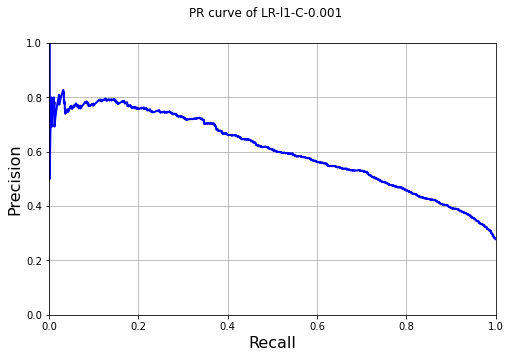

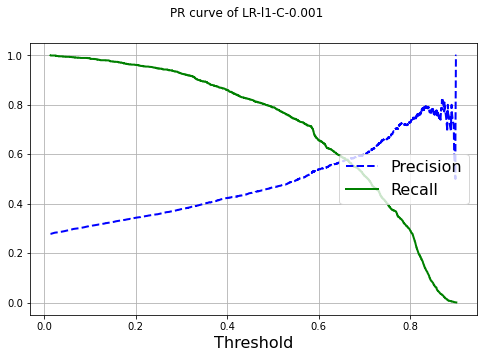

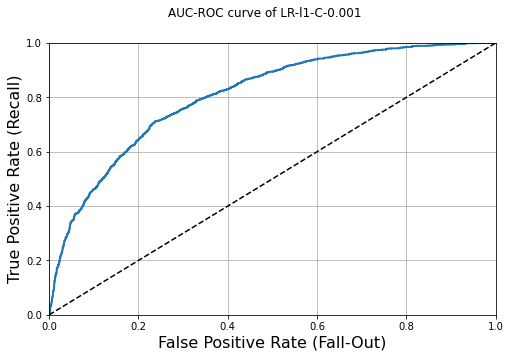

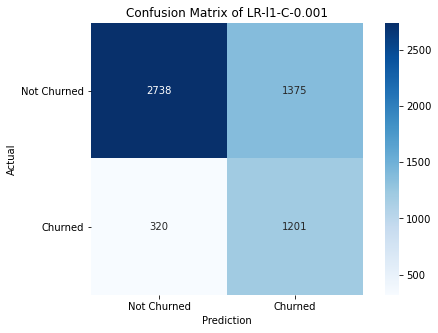

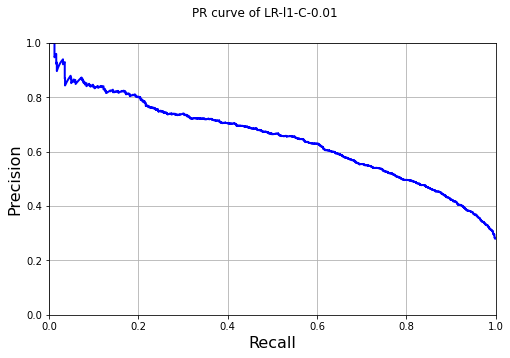

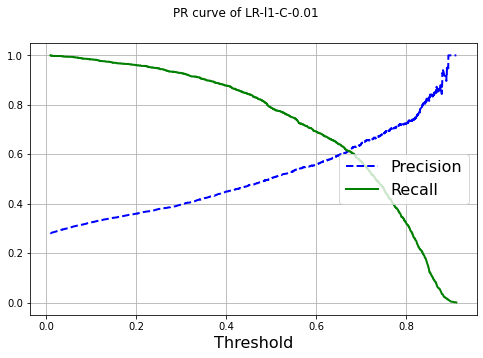

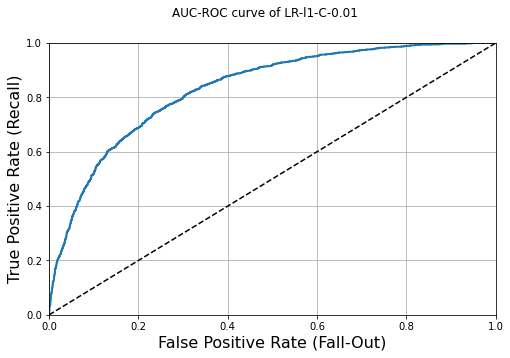

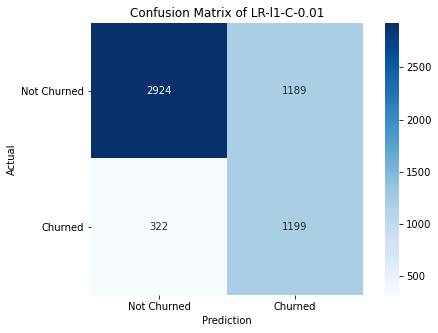

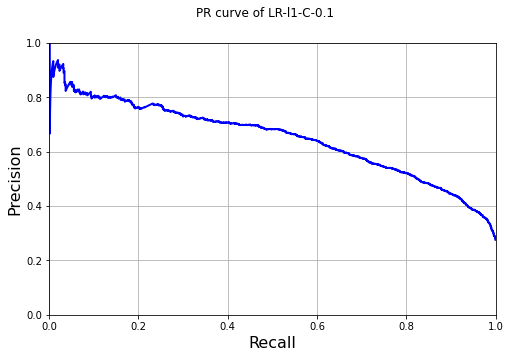

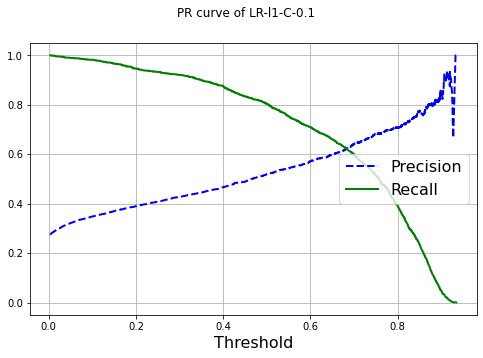

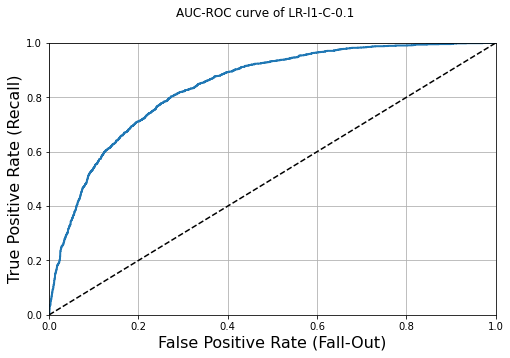

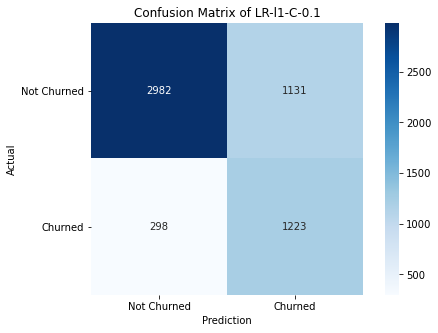

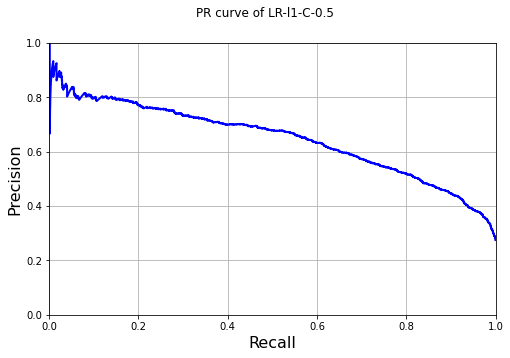

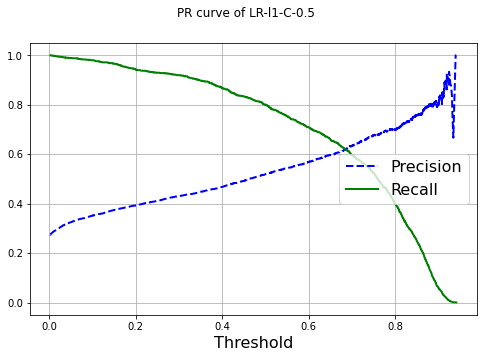

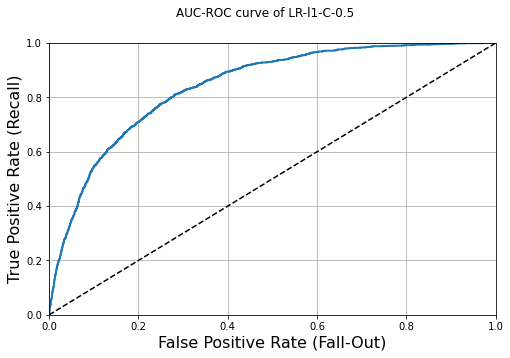

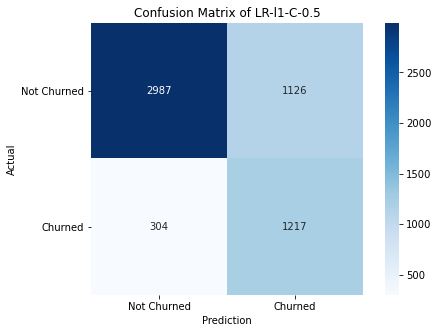

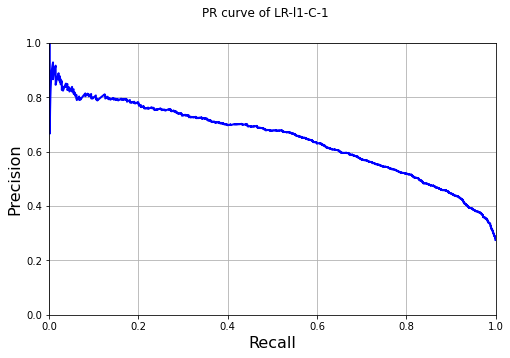

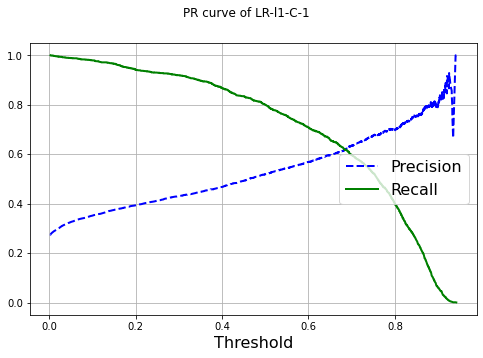

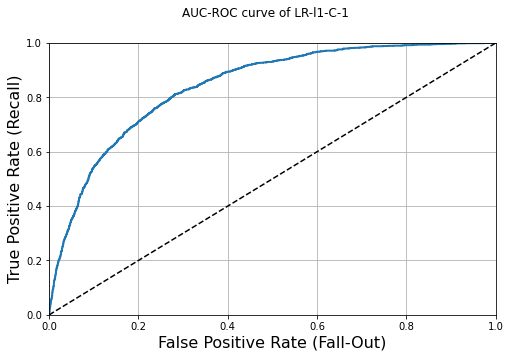

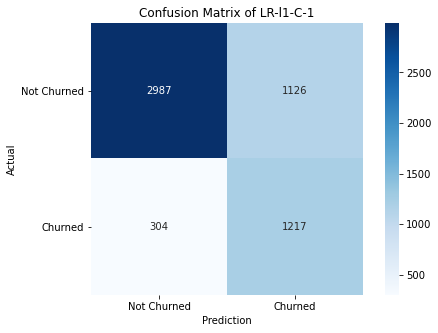

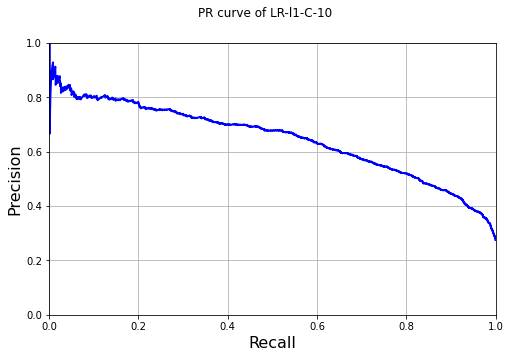

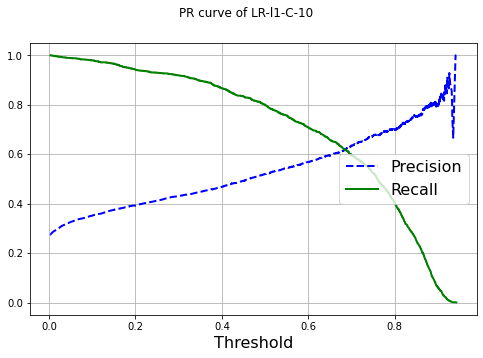

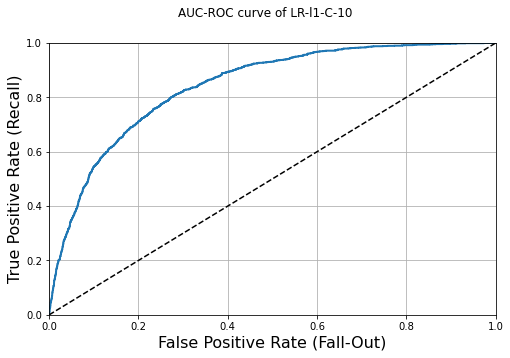

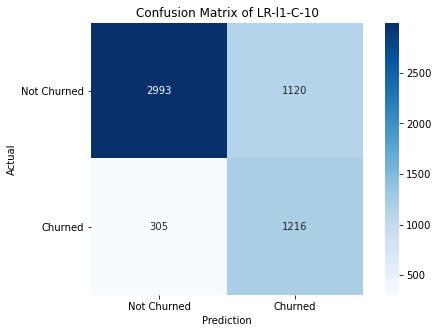

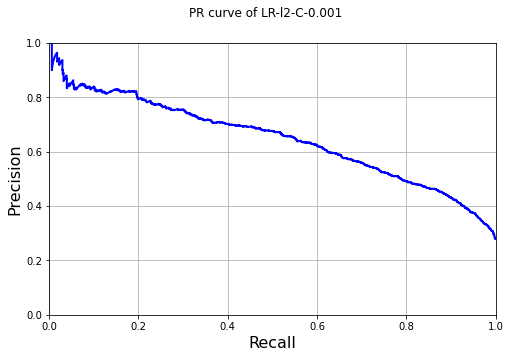

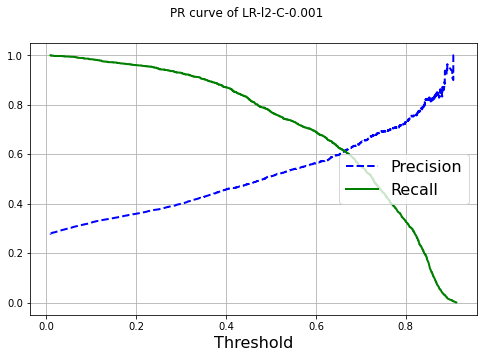

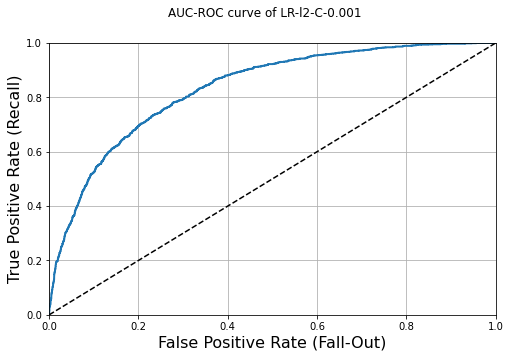

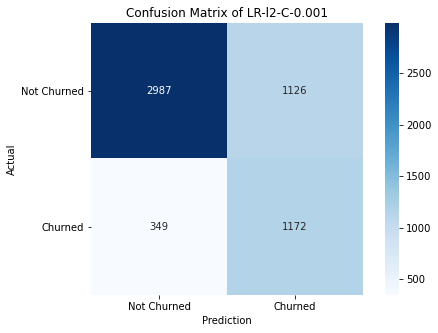

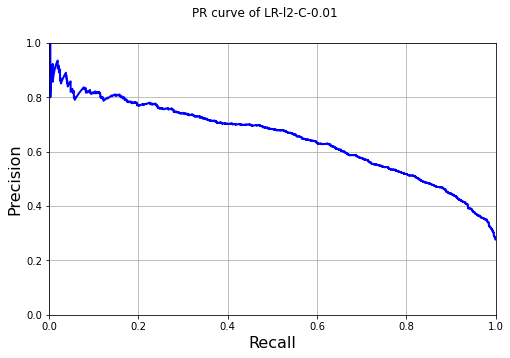

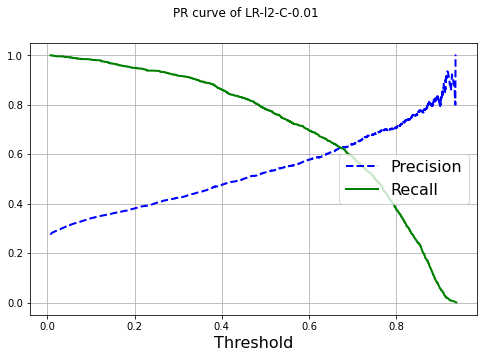

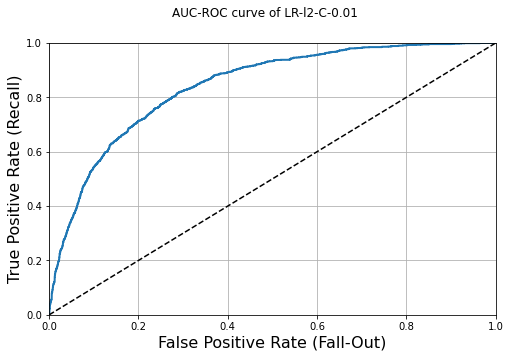

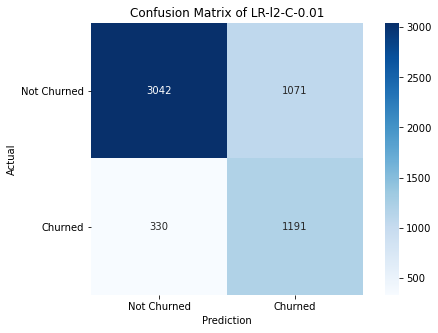

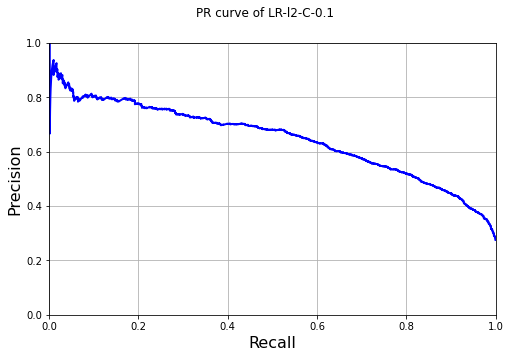

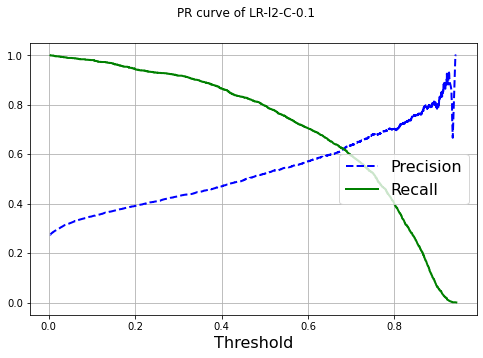

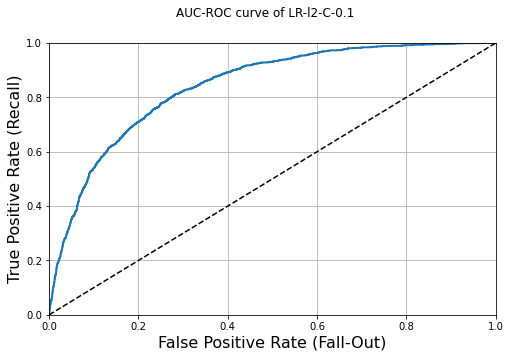

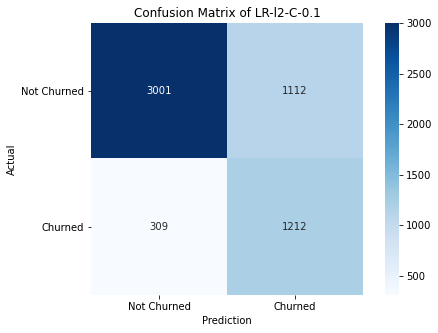

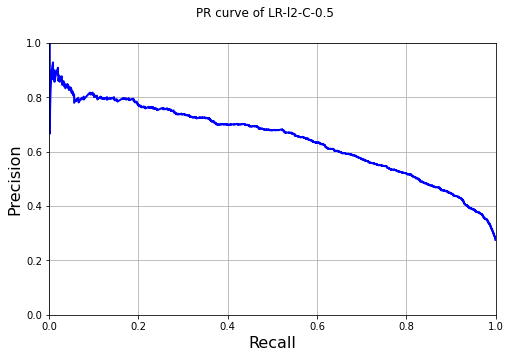

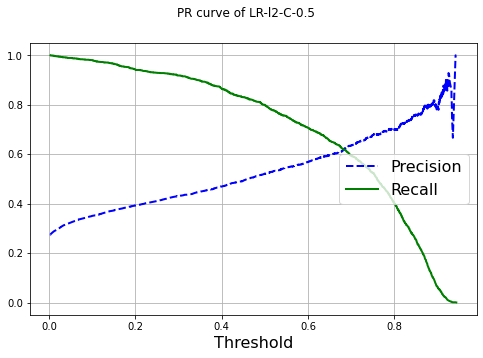

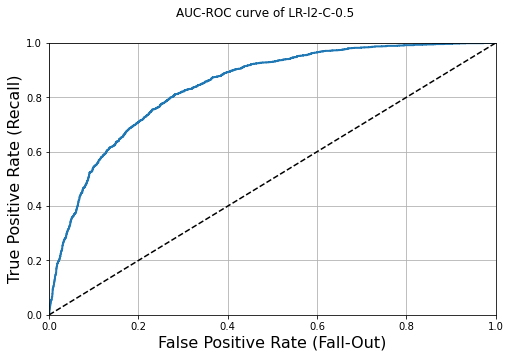

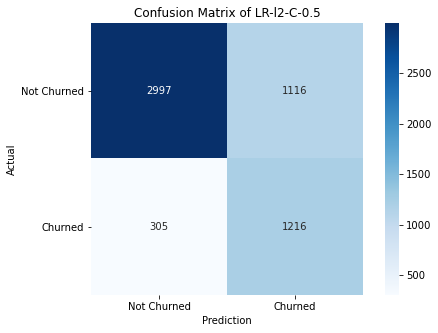

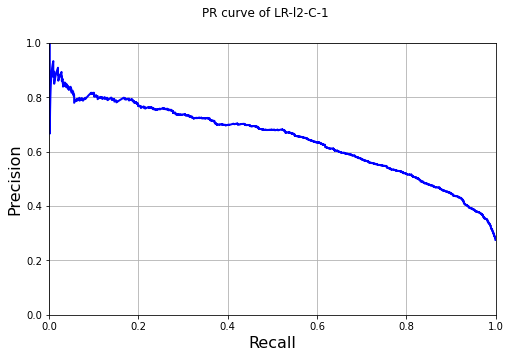

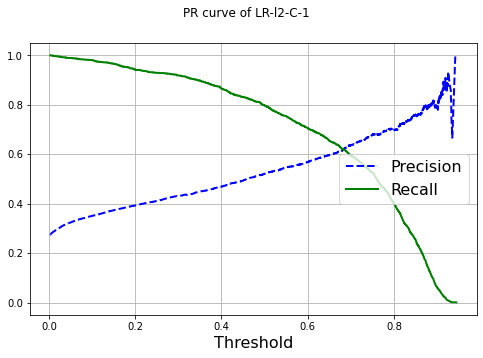

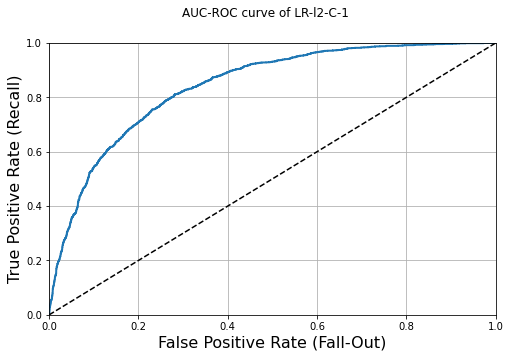

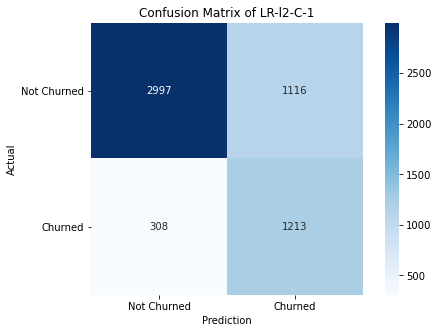

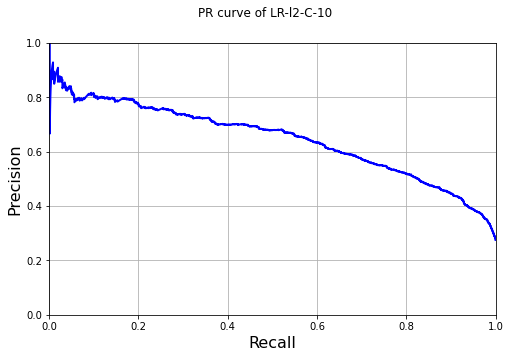

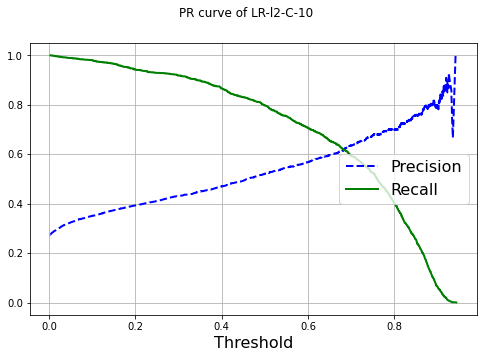

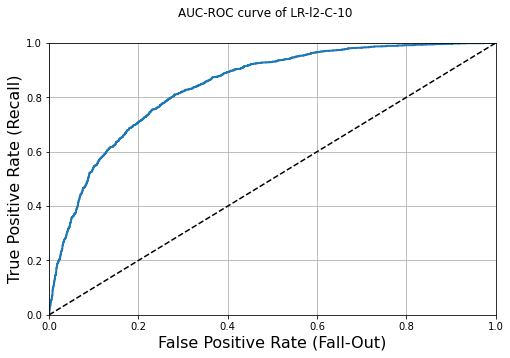

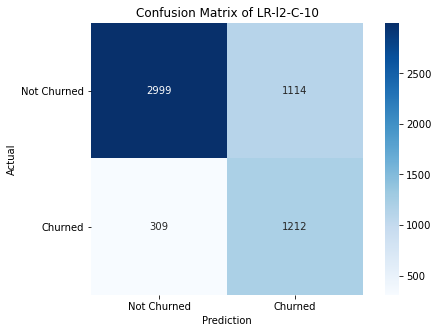

In [3]:
# l1 and l2 penalty

hyperparameter_tuning_model_to_evaluation_metrics_map = {}
smote_lr_model_names_to_model_objects_map = {}
for penalty in ['l1', 'l2']:
    for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
        lr_model = LogisticRegression(solver='liblinear', random_state= 42, C= C, penalty= penalty)
        lr_model_name = 'LR-{}-C-{}'.format(penalty, C)
        smote_lr_model_names_to_model_objects_map[lr_model_name]  = {
            'definition' : lr_model,
            'options' : {'scaling_required' : True, 'kfold' : 10}
        }

        print("Training : {}".format(lr_model_name))
        model_summary_with_smote(lr_model_name, smote_lr_model_names_to_model_objects_map[lr_model_name], 
                                 X_train_full_scaled, y_train_full, X_train_full_not_scaled, 
                                 hyperparameter_tuning_model_to_evaluation_metrics_map, 
                                 evaluation_metrics)

In [4]:
hyperparameter_tuning_model_to_mean_evaluation_metrics_df = get_model_to_mean_evaluation_metrics_with_smote_df(
    hyperparameter_tuning_model_to_evaluation_metrics_map, evaluation_metrics)

hyperparameter_tuning_model_to_mean_evaluation_metrics_df_by_f1_point_5 = hyperparameter_tuning_model_to_mean_evaluation_metrics_df.sort_values(by=['f1.5'],ascending=False)
hyperparameter_tuning_model_to_mean_evaluation_metrics_df_by_f1_point_5

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
2,LR-l1-C-0.1,0.688061,0.631327,0.842037,0.804076,0.520171,0.746358
9,LR-l2-C-0.5,0.686696,0.631179,0.841206,0.799493,0.521759,0.747779
5,LR-l1-C-10,0.686208,0.630516,0.841325,0.799488,0.520873,0.747070
4,LR-l1-C-1,0.685958,0.629924,0.841415,0.800146,0.519800,0.746182
3,LR-l1-C-0.5,0.685948,0.629924,0.841516,0.800146,0.519841,0.746182
8,LR-l2-C-0.1,0.685366,0.630379,0.841156,0.796857,0.521789,0.747779
10,LR-l2-C-1,0.685354,0.630107,0.841196,0.797519,0.521142,0.747247
11,LR-l2-C-10,0.685122,0.630045,0.841102,0.796861,0.521337,0.747424
7,LR-l2-C-0.01,0.680892,0.629662,0.841157,0.783050,0.526821,0.751329
1,LR-l1-C-0.01,0.670698,0.613623,0.831910,0.788304,0.502653,0.731805


As we can see in the table above, logistic regression model with L1 regularization and C value equal to 0.1 has highest `f1.5` value of `0.688061`.

### Hyperparameter tuning of Random Forest model

We will tune following parameters of random forest model:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- max_leaf_nodes = max number of leaf nodes
- bootstrap = method for sampling data points (with or without replacement)


In [5]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Max number of leaf nodes
max_leaf_nodes = np.arange(2,60,1)
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__max_leaf_nodes' : max_leaf_nodes,
               'rf__bootstrap': bootstrap}

In [6]:
from imblearn.pipeline import Pipeline

pipeline = Pipeline([("smote", SMOTE(random_state= 7)), ("rf", RandomForestClassifier(random_state=42))])

skfolds = StratifiedKFold(n_splits= 3, random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = pipeline, 
                               param_distributions = random_grid, 
                               scoring= f_scorer,
                               n_iter = 100, 
                               cv = skfolds, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)


In [7]:
# Fit the random search model
rf_random.fit(X_train_full_not_scaled, y_train_full)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=7)),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100,
                                                          110, None],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50

In [8]:
rf_random.best_params_

{'rf__n_estimators': 400,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 4,
 'rf__max_leaf_nodes': 2,
 'rf__max_features': 'auto',
 'rf__max_depth': None,
 'rf__bootstrap': False}

Training : best_random_forest_rcv
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78      4113
         1.0       0.48      0.81      0.61      1521

    accuracy                           0.72      5634
   macro avg       0.70      0.75      0.69      5634
weighted avg       0.79      0.72      0.73      5634



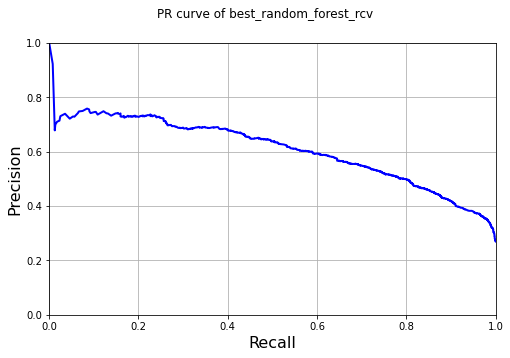

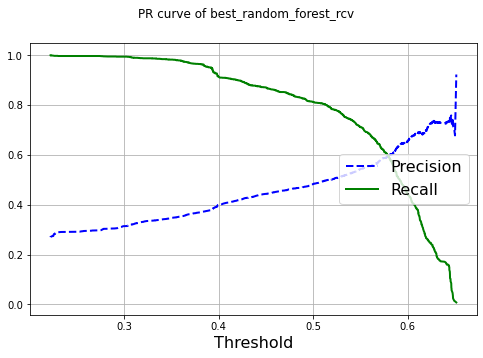

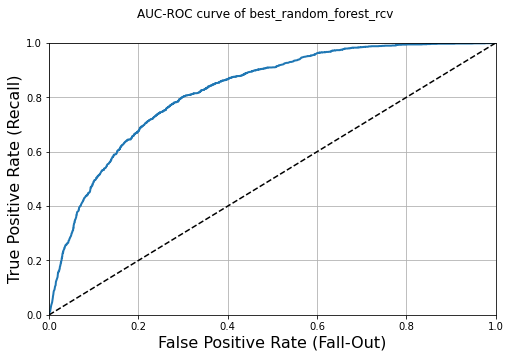

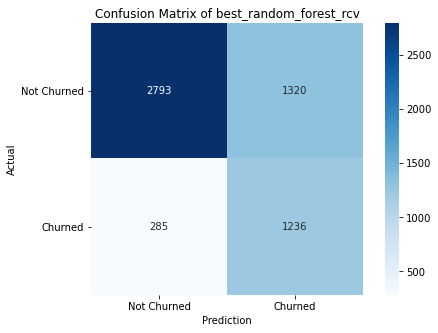

In [9]:
best_random_forest_rcv = RandomForestClassifier(
    n_estimators= 400,
    min_samples_split= 2,
    min_samples_leaf=  4,
    max_leaf_nodes= 2,   
    max_features= 'auto',
    max_depth= None,
    bootstrap= False,
    n_jobs=-1, 
    random_state= 42
)

rf_rcv_model_name = 'best_random_forest_rcv'
rf_rcv_model_map  = {
    'definition' : best_random_forest_rcv,
    'options' : {'scaling_required' : False, 'kfold' : 10}
}

print("Training : {}".format(rf_rcv_model_name))
model_summary_with_smote(rf_rcv_model_name, rf_rcv_model_map, 
                         X_train_full_scaled, y_train_full, X_train_full_not_scaled, 
                         hyperparameter_tuning_model_to_evaluation_metrics_map, 
                         evaluation_metrics)

In [10]:
hyperparameter_tuning_model_to_mean_evaluation_metrics_df = get_model_to_mean_evaluation_metrics_with_smote_df(
    hyperparameter_tuning_model_to_evaluation_metrics_map, evaluation_metrics)

hyperparameter_tuning_model_to_mean_evaluation_metrics_df_by_f1_point_5 = hyperparameter_tuning_model_to_mean_evaluation_metrics_df.sort_values(by=['f1.5'],ascending=False)
hyperparameter_tuning_model_to_mean_evaluation_metrics_df_by_f1_point_5

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
2,LR-l1-C-0.1,0.688061,0.631327,0.842037,0.804076,0.520171,0.746358
9,LR-l2-C-0.5,0.686696,0.631179,0.841206,0.799493,0.521759,0.747779
5,LR-l1-C-10,0.686208,0.630516,0.841325,0.799488,0.520873,0.747070
4,LR-l1-C-1,0.685958,0.629924,0.841415,0.800146,0.519800,0.746182
3,LR-l1-C-0.5,0.685948,0.629924,0.841516,0.800146,0.519841,0.746182
8,LR-l2-C-0.1,0.685366,0.630379,0.841156,0.796857,0.521789,0.747779
10,LR-l2-C-1,0.685354,0.630107,0.841196,0.797519,0.521142,0.747247
11,LR-l2-C-10,0.685122,0.630045,0.841102,0.796861,0.521337,0.747424
7,LR-l2-C-0.01,0.680892,0.629662,0.841157,0.783050,0.526821,0.751329
12,best_random_forest_rcv,0.671985,0.606463,0.824955,0.812655,0.483919,0.715119


There is not much improvement in `f1.5` score for Random Forest when hyperparameter tuning is done using RandomizedSearchCV. Keeping that in mind, we would stick with Logistic Regression for now.

## Ensemble Models

We will try `LGBMClassifier` and `XGBClassifier` with without smote and with smote.

### Without Smote

In [12]:
from lightgbm import LGBMClassifier

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      4113
           1       0.56      0.50      0.53      1521

    accuracy                           0.76      5634
   macro avg       0.69      0.68      0.68      5634
weighted avg       0.75      0.76      0.75      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
7,LGBM,0.513689,0.526257,0.802553,0.495068,0.562919,0.759672


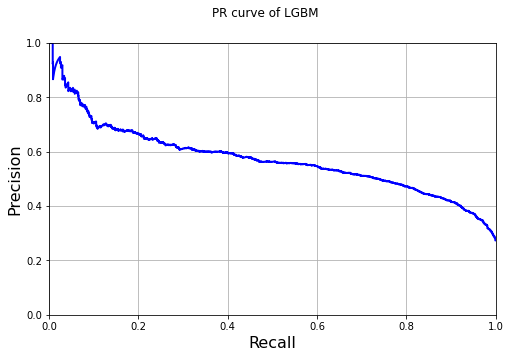

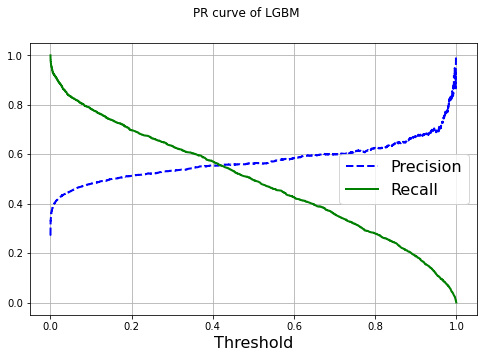

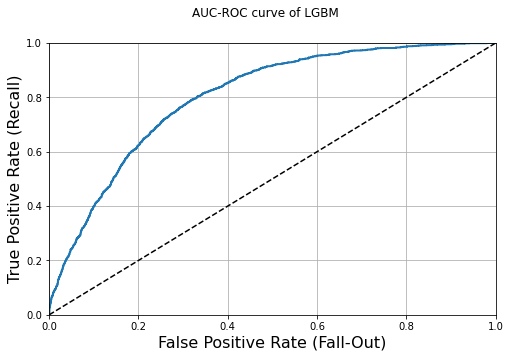

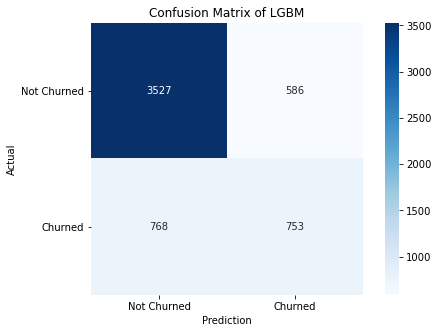

In [18]:
lgbm_c_model_name = 'LGBM'
lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)
cv = 10

# ensemble_evaluation_metrics_collector_map = defaultdict(list)
options = defaultdict(bool)

model_summary(lgbm_c_model_name, lgbm_c, X_train_full_scaled, y_train_full, X_train_scaled, 
                  y_train, X_val_scaled, y_val, cv, feature_names, evaluation_metrics, 
              phase_one_metrics_collector_map, options = options)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      4113
           1       0.56      0.49      0.52      1521

    accuracy                           0.76      5634
   macro avg       0.69      0.68      0.68      5634
weighted avg       0.75      0.76      0.75      5634



,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933
7,LGBM,0.513689,0.526257,0.802553,0.495068,0.562919,0.759672
8,XGBoost,0.512502,0.525178,0.792908,0.493774,0.562334,0.758788


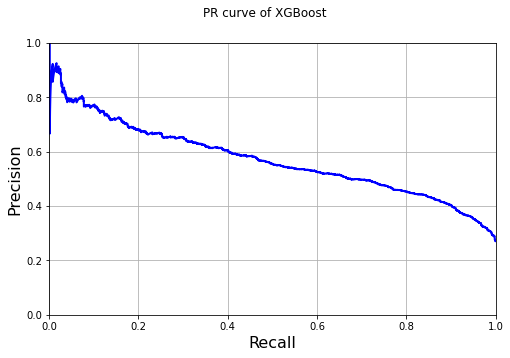

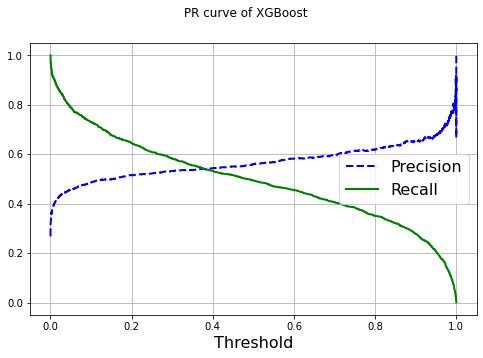

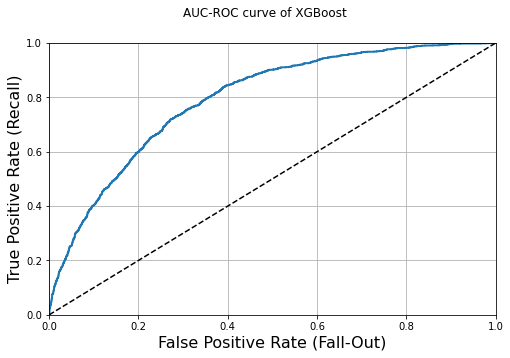

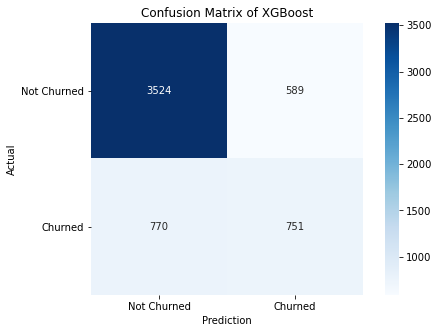

In [25]:
from xgboost import XGBClassifier

xgc_model_name = 'XGBoost'
xgc_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
cv = 10
options = defaultdict(bool)

model_summary(xgc_model_name, xgc_model, X_train_full_scaled, y_train_full, X_train_scaled, 
                  y_train, X_val_scaled, y_val, cv, feature_names, evaluation_metrics, phase_one_metrics_collector_map, 
              options = options)

### With Smote

In [21]:
smote_model_names_to_model_objects_map = get_smote_model_names_to_model_objects_map()

Training : LGBM_Smote
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      4113
         1.0       0.57      0.52      0.55      1521

    accuracy                           0.77      5634
   macro avg       0.70      0.69      0.69      5634
weighted avg       0.76      0.77      0.76      5634



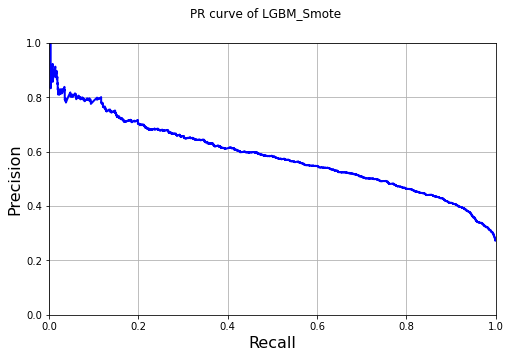

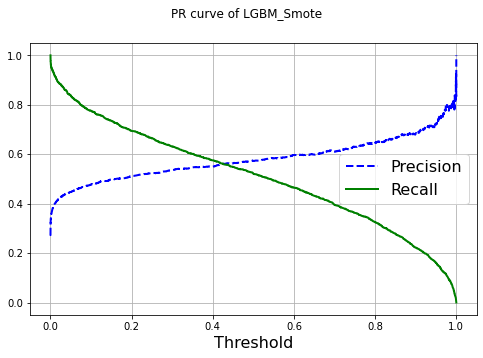

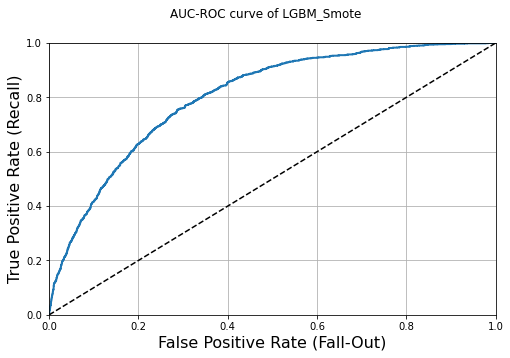

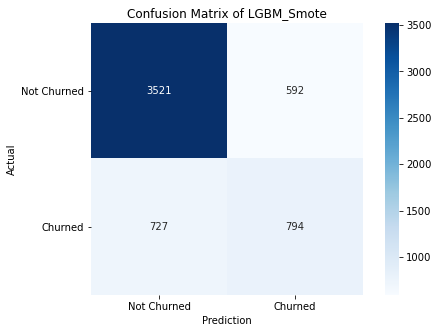

In [22]:
lgbm_c_model_name = 'LGBM_Smote'
lgbm_c_smote = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

smote_model_names_to_model_objects_map['LGBM_Smote']  = {
        'definition' : lgbm_c_smote,
        'options' : {'scaling_required' : True, 'kfold' : 10}
    }

print("Training : {}".format('LGBM_Smote'))
model_summary_with_smote(lgbm_c_model_name, smote_model_names_to_model_objects_map['LGBM_Smote'], 
                         X_train_full_scaled, 
                         y_train_full, X_train_full_not_scaled, 
                         model_to_evaluation_metrics_with_smote_map, evaluation_metrics)

In [23]:
model_to_mean_evaluation_metrics_with_smote_df = get_model_to_mean_evaluation_metrics_with_smote_df(
    model_to_evaluation_metrics_with_smote_map, evaluation_metrics
    )
model_to_mean_evaluation_metrics_with_smote_df.sort_values(by=['f1.5'],ascending=False)

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.685354,0.630107,0.841196,0.797519,0.521142,0.747247
5,LDA,0.677498,0.622697,0.838220,0.788966,0.514777,0.741742
6,B_SVC,0.670541,0.604438,0.831488,0.812757,0.481121,0.722043
2,RF,0.666404,0.627118,0.837751,0.740987,0.544078,0.761982
1,DT,0.636844,0.591624,0.791567,0.725860,0.499632,0.729318
4,GNB,0.622011,0.568577,0.766290,0.732405,0.464943,0.699860
3,KNN,0.588759,0.548260,0.739152,0.667982,0.465316,0.702872
7,LGBM_Smote,0.536533,0.546376,0.803565,0.522037,0.575239,0.765888


Training : XGBoost_Smote
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      4113
         1.0       0.56      0.51      0.54      1521

    accuracy                           0.76      5634
   macro avg       0.70      0.68      0.69      5634
weighted avg       0.76      0.76      0.76      5634



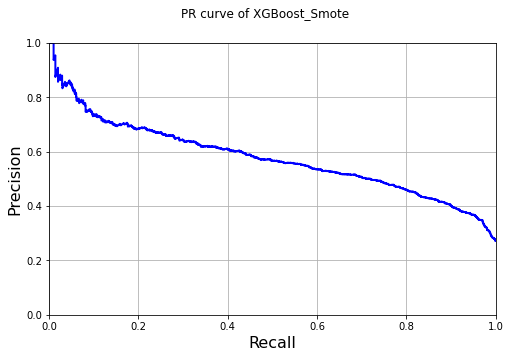

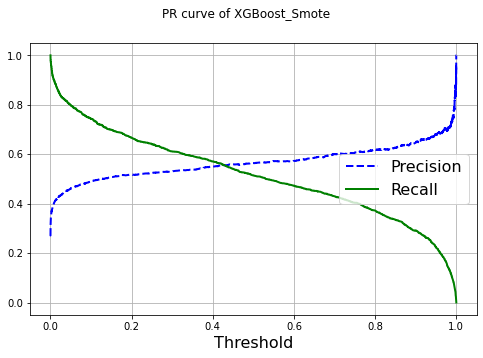

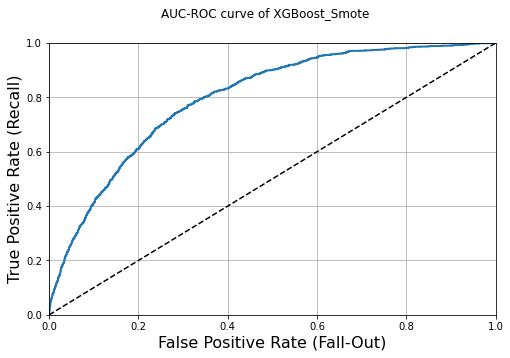

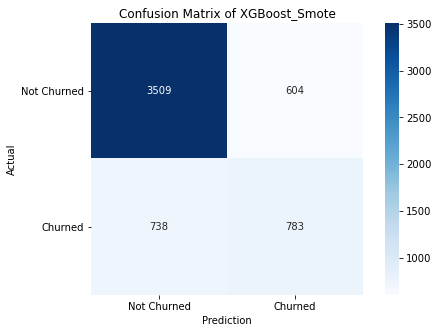

In [26]:

xgc_model_name = 'XGBoost_Smote'
xgc_smote_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

smote_model_names_to_model_objects_map['XGBoost_Smote']  = {
        'definition' : xgc_smote_model,
        'options' : {'scaling_required' : True, 'kfold' : 10}
    }

print("Training : {}".format('XGBoost_Smote'))
model_summary_with_smote(xgc_model_name, smote_model_names_to_model_objects_map['XGBoost_Smote'], 
                         X_train_full_scaled, 
                         y_train_full, X_train_full_not_scaled, 
                         model_to_evaluation_metrics_with_smote_map, evaluation_metrics)

In [27]:
model_to_mean_evaluation_metrics_with_smote_df = get_model_to_mean_evaluation_metrics_with_smote_df(
    model_to_evaluation_metrics_with_smote_map, evaluation_metrics
    )
model_to_mean_evaluation_metrics_with_smote_df.sort_values(by=['f1.5'],ascending=False)

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.685354,0.630107,0.841196,0.797519,0.521142,0.747247
5,LDA,0.677498,0.622697,0.838220,0.788966,0.514777,0.741742
6,B_SVC,0.670541,0.604438,0.831488,0.812757,0.481121,0.722043
2,RF,0.666404,0.627118,0.837751,0.740987,0.544078,0.761982
1,DT,0.636844,0.591624,0.791567,0.725860,0.499632,0.729318
4,GNB,0.622011,0.568577,0.766290,0.732405,0.464943,0.699860
3,KNN,0.588759,0.548260,0.739152,0.667982,0.465316,0.702872
7,LGBM_Smote,0.536533,0.546376,0.803565,0.522037,0.575239,0.765888
8,XGBoost_Smote,0.529136,0.538677,0.798202,0.514809,0.565925,0.761805
